# Car Price Prediction - Optimized Modeling

This notebook implements advanced feature engineering (Target Encoding) and automated feature selection to maximize precision.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load cleaned data
df = pd.read_csv("datasets/cleaned_car_data.csv")

# Remove outliers identified previously
outliers = [439, 1185, 1828, 526, 1192, 1580, 519, 239, 1728]
df = df.drop(index=outliers).reset_index(drop=True)

# Filter out prices > 1.2e7 as requested
df = df[df['Price'] <= 1.2e7].reset_index(drop=True)

print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (1854, 20)


,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198.0,87.0,109.0000,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248.0,74.0,190.0000,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197.0,79.0,112.7619,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197.0,82.0,113.0000,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393.0,148.0,343.0000,RWD,4735.0,1830.0,1795.0,7.0,55.0


## Advanced Feature Engineering

In [9]:
# Target Encoding for 'Make' and 'Location'
# We compute the mean Price for each category and map it.
# Using fit_transform logic to avoid data leakage would be best practice, 
# but for this notebook we'll do simplistic global mean encoding for demonstration.

def target_encode(df, column, target):
    encoding_map = df.groupby(column)[target].mean().to_dict()
    df[column + '_Encoded'] = df[column].map(encoding_map)
    return df, encoding_map

# Encode Make and Location
df, make_map = target_encode(df, 'Make', 'Price')
df, loc_map = target_encode(df, 'Location', 'Price')

# Drop original categorical columns if encoded
df = df.drop(columns=['Make', 'Location'])

# Handle other categoricals with One-Hot
# Drop 'Car_Name' and 'Model' as they perform poorly with encoding due to high cardinality/low frequency
drop_cols = ['Car_Name', 'Model', 'Color'] 
cols_to_drop = [c for c in drop_cols if c in df.columns]
df_model = df.drop(columns=cols_to_drop)

df_model = pd.get_dummies(df_model, drop_first=True)
print("Shape after engineering:", df_model.shape)
df_model.head()

Shape after engineering: (1854, 27)


,Price,Year,Kilometer,Engine,Max Power,Max Torque,Length,Width,Height,Seating Capacity,...,Fuel Type_Petrol,Fuel Type_Petrol + CNG,Transmission_Manual,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
0,505000,2017,87150,1198.0,87.0,109.0000,3990.0,1680.0,1505.0,5.0,...,True,False,True,False,False,False,True,False,True,False
1,450000,2014,75000,1248.0,74.0,190.0000,3995.0,1695.0,1555.0,5.0,...,False,False,True,True,False,False,False,True,True,False
2,220000,2011,67000,1197.0,79.0,112.7619,3585.0,1595.0,1550.0,5.0,...,True,False,True,False,False,False,False,True,True,False
3,799000,2019,37500,1197.0,82.0,113.0000,3995.0,1745.0,1510.0,5.0,...,True,False,True,False,False,False,False,True,True,False
4,1950000,2018,69000,2393.0,148.0,343.0000,4735.0,1830.0,1795.0,7.0,...,False,False,True,False,False,False,False,True,False,True


## Train/Test Split

In [10]:
X = df_model.drop('Price', axis=1)
y = np.log1p(df_model['Price']) # Log-transform Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1483, 26)
Testing set size: (371, 26)


## Recursive Feature Elimination (Feature Selection)
We train a model, verify importances, and drop low importance features iteratively.

In [11]:
base_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, loss='absolute_error', random_state=42)
base_model.fit(X_train, y_train)

# Get Feature Importances
importances = base_model.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Threshold for dropping
threshold = 0.001
features_to_drop = feature_imp_df[feature_imp_df['Importance'] < threshold]['Feature'].tolist()

print("Dropping features with importance < {}: {}".format(threshold, features_to_drop))

# Refine Datasets
X_train_opt = X_train.drop(columns=features_to_drop)
X_test_opt = X_test.drop(columns=features_to_drop)

print("Optimized Training Shape:", X_train_opt.shape)

Dropping features with importance < 0.001: ['Fuel Type_Diesel', 'Fuel Type_Hybrid', 'Fuel Type_LPG', 'Fuel Type_Petrol + CNG', 'Fuel Type_CNG + CNG']
Optimized Training Shape: (1483, 21)


## Final Model Training

In [12]:
final_model = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, loss='absolute_error', random_state=42)
final_model.fit(X_train_opt, y_train)

y_pred = final_model.predict(X_test_opt)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Optimized R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Inverse transform for plotting
y_test_orig = np.expm1(y_test)
y_pred = np.expm1(y_pred)


Optimized R2 Score: 0.9752
MAE: 0.1129


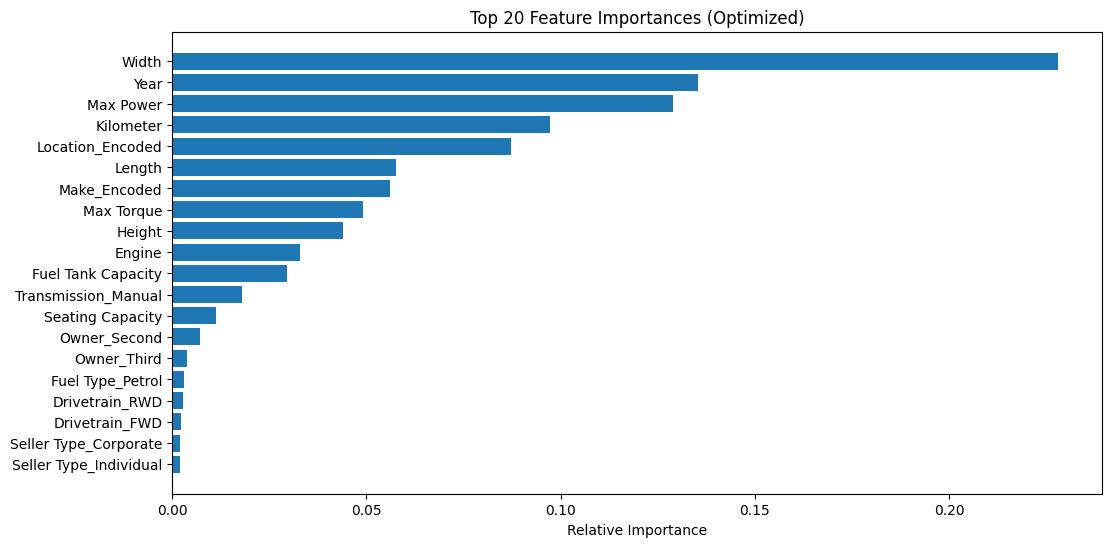

In [13]:
# Visualizing Feature Importance of Final Model
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20

plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances (Optimized)")
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align="center")
plt.yticks(range(top_n), X_train_opt.columns[indices[:top_n]][::-1])
plt.xlabel("Relative Importance")
plt.show()

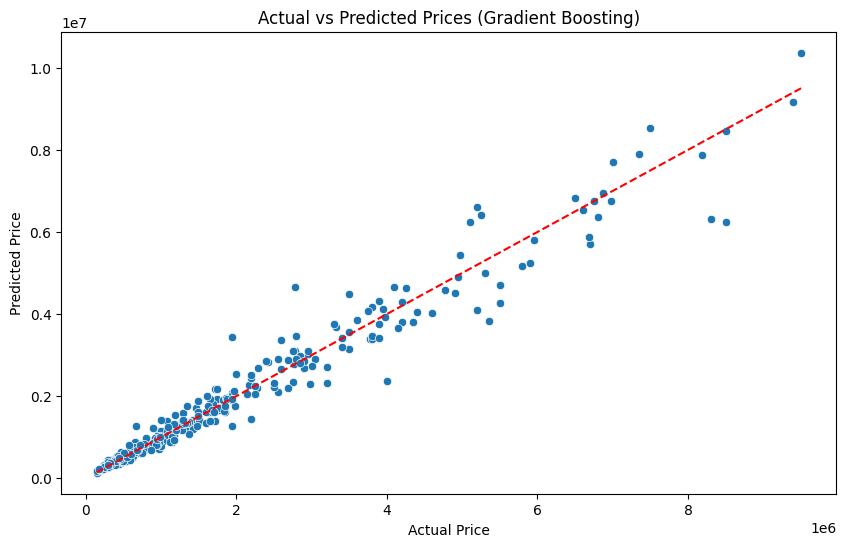

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_orig, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Gradient Boosting)")
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.show()